In [38]:
# make sure we're in the right env; in bash you'd do:
#    conda activate pymc_clean   # or whichever env has arviz, sklearn, etc.
# ----------------------------------------------------------------------------
import numpy  as np
import pandas as pd
import pymc   as pm
import arviz  as az
import matplotlib.pyplot as plt

# use one of the built-in arviz styles (not "arviz-viz", which no longer exists)
az.style.use("arviz-darkgrid")

# scikit-learn only when we actually need it
from sklearn.model_selection import KFold

# make things reproducible
np.random.seed(42)


In [40]:
# 1) simulate 100 rows of 2 predictors
n = 100
X = np.random.normal(size=(n, 2))

# 2) true parameters
true_beta = np.array([1.0, -0.5])

# 3) linear predictor
eta = X @ true_beta

# 4) cut‐points for three categories
cutpoints = [-0.5, 0.5]

# 5) generate an ordinal outcome
y = np.digitize(eta, cutpoints)  # values in {0,1,2}

# wrap in a DataFrame for convenience
df = pd.DataFrame(X, columns=["x1", "x2"])
df["y"] = y

df.head()


,x1,x2,y
0,0.496714,-0.138264,2
1,0.647689,1.523030,1
2,-0.234153,-0.234137,1
3,1.579213,0.767435,2
4,-0.469474,0.542560,0


In [48]:
with pm.Model() as prior_model:
    β0 = pm.Normal("β0", 0, 2)
    β1 = pm.Normal("β1", 0, 2, shape=2)
    cut = pm.Normal("cut", 0, 5, shape=2)
    
    η = β0 + pm.math.dot(df[["x1","x2"]].values, β1)
    θ = pm.math.sigmoid(cut - η[:, None])
    # convert to 3‐category probs
    p0 = θ[:, 0]
    p1 = θ[:, 1] - θ[:, 0]
    p2 = 1 - θ[:, 1]
    p  = pm.math.stack([p0, p1, p2], axis=1)
    
    y_pp = pm.Categorical("y_pp", p=p, shape=n)

    prior_pred = pm.sample_prior_predictive(200)

# flatten the 200×n_prior array into one long vector
prior_y = prior_pred["y_obs"].ravel()

az.plot_dist_comparison(
    data=prior_y,           # use "y_obs" not "y_pp"
    kind="hist",
    prior_kwargs     = dict(alpha=0.2, label="prior draws"),
    posterior_kwargs = dict(alpha=0.2),
    observed_kwargs  = dict(color="k",
                             linestyle="--",
                             linewidth=2,
                             label="none (prior only)"),
)
plt.legend();


Sampling: [cut, y_pp, β0, β1]


KeyError: 'y_obs'

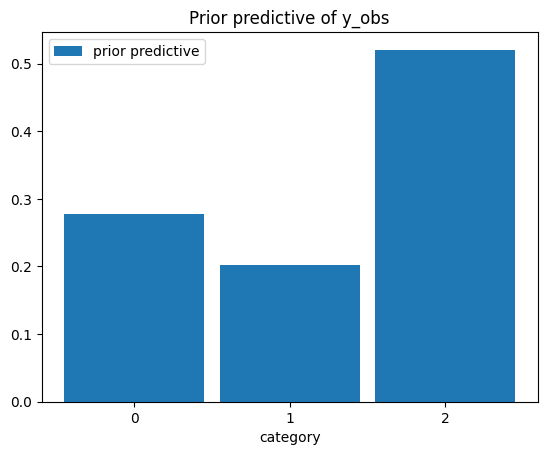

In [14]:
prior_idata = results["prior_idata"]["cum"]
# flatten and plot
y_pp = prior_idata.prior_predictive["y_obs"].values.flatten()
ax = az.plot_dist(y_pp, kind="hist", label="prior predictive")
ax.set(title="Prior predictive of y_obs", xlabel="category")
plt.show()

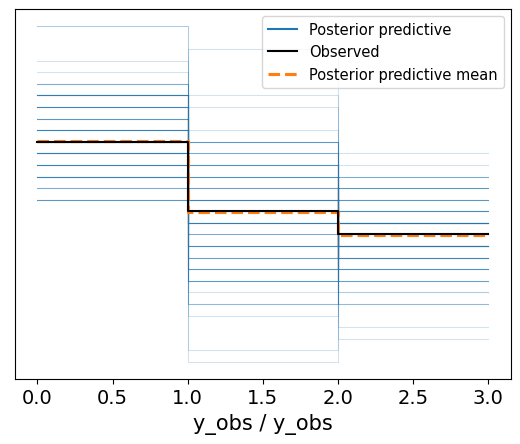

In [28]:
ppc_idata = results["ppc"]

# 1) built‐in PPC
az.plot_ppc(ppc_idata, var_names=["y_obs"], num_pp_samples=100)
plt.show()


In [34]:
# grab the obs and the draws
obs = ppc_idata.observed_data["y_obs"].values         # shape (100,)
pps = ppc_idata.posterior_predictive["y_obs"].values  # shape (n_chains, n_draws, 100)

# flatten chains & draws into one long sample axis
pps = pps.reshape(-1, pps.shape[-1])  # now shape (n_chains*n_draws, 100)

# now collapse the 100 predicted values per sample into one vector of predictions
# by concatenating over the 0th axis
pps = pps.flatten()  # shape (n_chains*n_draws*100,)

az.plot_dist_comparison(
    obs,
    "hist",           # <— this is the kind
    predictions=pps,  # <— posterior-predictive samples
    xlabel="y_obs"
)
plt.show()


TypeError: plot_dist_comparison() got an unexpected keyword argument 'predictions'

In [36]:
import arviz as az
from inspect import signature
print(signature(az.plot_dist_comparison))

(data, kind='latent', figsize=None, textsize=None, var_names=None, coords=None, combine_dims=None, transform=None, legend=True, labeller=None, ax=None, prior_kwargs=None, posterior_kwargs=None, observed_kwargs=None, backend=None, backend_kwargs=None, show=None)
